# Model Training

In [398]:
import numpy as np 
import pandas as pd

In [399]:
df  = pd.read_csv("dataset2_preprocessing_done.csv")

In [400]:
df.head()

,Unnamed: 0,Category,Description,carbs,protein,fat,fiber,calories,goal_tag,diet_type
0,0,milk,"milk, nfs",-0.803888,-0.708719,-0.802787,-0.756657,-1.161451,4,1
1,1,milk,"milk, whole",-0.812894,-0.715474,-0.657086,-0.756657,-1.088393,4,1
2,2,milk,"milk, low sodium, whole",-0.822350,-0.735738,-0.625779,-0.756657,-1.082608,4,1
3,3,milk,"milk, calcium fortified, whole",-0.812894,-0.715474,-0.657086,-0.756657,-1.088393,4,1
4,4,milk,"milk, calcium fortified, low fat (1%)",-0.789478,-0.704216,-0.928017,-0.756657,-1.220195,4,1


In [401]:
df.drop(df.columns[0],inplace=True,axis=1)

In [402]:
df.head()

,Category,Description,carbs,protein,fat,fiber,calories,goal_tag,diet_type
0,milk,"milk, nfs",-0.803888,-0.708719,-0.802787,-0.756657,-1.161451,4,1
1,milk,"milk, whole",-0.812894,-0.715474,-0.657086,-0.756657,-1.088393,4,1
2,milk,"milk, low sodium, whole",-0.822350,-0.735738,-0.625779,-0.756657,-1.082608,4,1
3,milk,"milk, calcium fortified, whole",-0.812894,-0.715474,-0.657086,-0.756657,-1.088393,4,1
4,milk,"milk, calcium fortified, low fat (1%)",-0.789478,-0.704216,-0.928017,-0.756657,-1.220195,4,1


In [403]:
def simulate_match_score(row):
    prot = row["protein"]
    fat = row["fat"]
    carbs = row["carbs"]
    cal = row["calories"]
    fiber = row["fiber"]
    goal = row["goal_tag"]

    if goal == 0:  # gain
        score = 0.3 * prot + 0.3 * carbs + 0.3 * cal - 0.1 * fat
    elif goal == 1:  # general
        score = 0.25 * prot + 0.25 * carbs + 0.25 * cal - 0.25 * fat
    elif goal == 2:  # lean_protein
        score = 0.5 * prot - 0.2 * fat + 0.1 * fiber
    elif goal == 3:  # maintenance
        score = 0.3 * prot + 0.3 * carbs + 0.2 * fat + 0.2 * cal
    elif goal == 4:  # weight_loss
        score = 0.4 * prot - 0.3 * fat - 0.2 * cal + 0.1 * fiber
    else:
        score = 0.0

    return np.clip((score + 1) / 2, 0, 1)  # Normalize between 0 and 1

In [404]:
df["match_score"] = df.apply(simulate_match_score, axis=1)

In [405]:
df.head()

,Category,Description,carbs,protein,fat,fiber,calories,goal_tag,diet_type,match_score
0,milk,"milk, nfs",-0.803888,-0.708719,-0.802787,-0.756657,-1.161451,4,1,0.556986
1,milk,"milk, whole",-0.812894,-0.715474,-0.657086,-0.756657,-1.088393,4,1,0.526475
2,milk,"milk, low sodium, whole",-0.822350,-0.735738,-0.625779,-0.756657,-1.082608,4,1,0.517147
3,milk,"milk, calcium fortified, whole",-0.812894,-0.715474,-0.657086,-0.756657,-1.088393,4,1,0.526475
4,milk,"milk, calcium fortified, low fat (1%)",-0.789478,-0.704216,-0.928017,-0.756657,-1.220195,4,1,0.582546


In [406]:
df.to_csv("dataset3_Finalized_Dataset.csv")

### Train Test Split

In [408]:
from sklearn.model_selection import train_test_split

In [409]:
X = df[["carbs","protein","fat","fiber","calories","goal_tag","diet_type"]]
y = df["match_score"]

In [410]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Model Training

In [412]:
# importing models
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import mlflow

In [413]:
model_list = []
r2_list = []

In [414]:
models = {
    'Linear Regression' : LinearRegression(),
    'Lasso' : Lasso(),
    'Ridge' : Ridge(),
    'K-Neighbors Regressor' : KNeighborsRegressor(),
    'Decision Tree' : DecisionTreeRegressor(),
    'Random Forest Regressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor(),
    'CatBoosting Regressor' : CatBoostRegressor(verbose=False),
    'AdaBoost Regressor' : AdaBoostRegressor()
}

In [415]:
def evaluate_model(true,predicted):
    mae = mean_absolute_error(true,predicted)
    mse = mean_squared_error(true,predicted)
    rmse = np.sqrt(mean_squared_error(true,predicted))
    r2 = r2_score(true,predicted)
    return mae , rmse , r2

### Tracking Models using mlflow

In [417]:
mlflow.set_experiment("Diet_MatchScore_Regression_Models1.0")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
for model_name, model in models.items():
    with mlflow.start_run():
        # Train model
        model.fit(X_train, y_train)

        # Predict
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Evaluate
        model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
        model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

        # Log metrics
        mlflow.log_metrics({
            "train_mae": model_train_mae,
            "train_rmse": model_train_rmse,
            "train_r2": model_train_r2,
            "test_mae": model_test_mae,
            "test_rmse": model_test_rmse,
            "test_r2": model_test_r2
        })

        # Log model
        if model_name == "XGBRegressor":
            mlflow.xgboost.log_model(model,model_name)
        elif model_name == "CatBoosting Regressor":
            mlflow.catboost.log_model(model, model_name)
        else:
            mlflow.sklearn.log_model(model, model_name)

        # Print results to console
        print(f"Model Performance on training set for {model_name}")
        print('- Root MeanSquared Error: {:.4f}'.format(model_train_rmse))
        print('- Mean Absolute Error: {:.4f}'.format(model_train_mae))
        print('- R2 Score: {:.4f}'.format(model_train_r2))
        print("\n")
        print(f"Model Performance on test set for {model_name}")
        print('- Root MeanSquared Error: {:.4f}'.format(model_test_rmse))
        print('- Mean Absolute Error: {:.4f}'.format(model_test_mae))
        print('- R2 Score: {:.4f}'.format(model_test_r2))
        print("----------------------------------------------------------------")

2025/07/11 18:24:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 18:24:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 18:24:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model Performance on training set for Linear Regression
- Root MeanSquared Error: 0.0914
- Mean Absolute Error: 0.0707
- R2 Score: 0.7126


Model Performance on test set for Linear Regression
- Root MeanSquared Error: 0.1010
- Mean Absolute Error: 0.0766
- R2 Score: 0.6484
----------------------------------------------------------------
🏃 View run serious-lamb-702 at: http://127.0.0.1:5000/#/experiments/105883887422754184/runs/a29db1803a3e4407a79208f2672832db
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/105883887422754184


2025/07/11 18:24:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 18:24:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model Performance on training set for Lasso
- Root MeanSquared Error: 0.1705
- Mean Absolute Error: 0.1326
- R2 Score: 0.0000


Model Performance on test set for Lasso
- Root MeanSquared Error: 0.1704
- Mean Absolute Error: 0.1329
- R2 Score: -0.0000
----------------------------------------------------------------
🏃 View run brawny-moose-607 at: http://127.0.0.1:5000/#/experiments/105883887422754184/runs/41c77f15f3814e2c958deb90835c086d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/105883887422754184


2025/07/11 18:24:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 18:24:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model Performance on training set for Ridge
- Root MeanSquared Error: 0.0914
- Mean Absolute Error: 0.0707
- R2 Score: 0.7126


Model Performance on test set for Ridge
- Root MeanSquared Error: 0.1010
- Mean Absolute Error: 0.0766
- R2 Score: 0.6485
----------------------------------------------------------------
🏃 View run trusting-bear-311 at: http://127.0.0.1:5000/#/experiments/105883887422754184/runs/4d0c9e0ed61049afa7e619105ac2dc53
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/105883887422754184


2025/07/11 18:24:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 18:24:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model Performance on training set for K-Neighbors Regressor
- Root MeanSquared Error: 0.0221
- Mean Absolute Error: 0.0117
- R2 Score: 0.9833


Model Performance on test set for K-Neighbors Regressor
- Root MeanSquared Error: 0.0310
- Mean Absolute Error: 0.0162
- R2 Score: 0.9668
----------------------------------------------------------------
🏃 View run brawny-midge-339 at: http://127.0.0.1:5000/#/experiments/105883887422754184/runs/2c25ec59c43b479587a5ca16b7d0debe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/105883887422754184


2025/07/11 18:24:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Performance on training set for Decision Tree
- Root MeanSquared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000


Model Performance on test set for Decision Tree
- Root MeanSquared Error: 0.0266
- Mean Absolute Error: 0.0126
- R2 Score: 0.9756
----------------------------------------------------------------
🏃 View run bittersweet-crow-307 at: http://127.0.0.1:5000/#/experiments/105883887422754184/runs/511817a4a71e4d4cad2179bd69d766b8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/105883887422754184


2025/07/11 18:24:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 18:24:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Performance on training set for Random Forest Regressor
- Root MeanSquared Error: 0.0071
- Mean Absolute Error: 0.0035
- R2 Score: 0.9983


Model Performance on test set for Random Forest Regressor
- Root MeanSquared Error: 0.0221
- Mean Absolute Error: 0.0102
- R2 Score: 0.9831
----------------------------------------------------------------
🏃 View run monumental-lamb-507 at: http://127.0.0.1:5000/#/experiments/105883887422754184/runs/f7e5cfdc42974c789ff596f917494bc1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/105883887422754184


2025/07/11 18:24:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Data Science Learning\Projects\NutriGoal-AI-Powered-Personalized-Diet-Planner\dietenv\lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [18:24:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/07/11 18:24:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Performance on training set for XGBRegressor
- Root MeanSquared Error: 0.0026
- Mean Absolute Error: 0.0018
- R2 Score: 0.9998


Model Performance on test set for XGBRegressor
- Root MeanSquared Error: 0.0211
- Mean Absolute Error: 0.0096
- R2 Score: 0.9847
----------------------------------------------------------------
🏃 View run clumsy-fish-417 at: http://127.0.0.1:5000/#/experiments/105883887422754184/runs/a40c4e9550f348ec88ed8d9a696568e4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/105883887422754184


2025/07/11 18:24:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 18:24:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Performance on training set for CatBoosting Regressor
- Root MeanSquared Error: 0.0043
- Mean Absolute Error: 0.0031
- R2 Score: 0.9994


Model Performance on test set for CatBoosting Regressor
- Root MeanSquared Error: 0.0139
- Mean Absolute Error: 0.0058
- R2 Score: 0.9934
----------------------------------------------------------------
🏃 View run angry-fox-668 at: http://127.0.0.1:5000/#/experiments/105883887422754184/runs/e4092ba2572a4cd1a6451a357022b4d2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/105883887422754184


2025/07/11 18:24:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 18:24:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Performance on training set for AdaBoost Regressor
- Root MeanSquared Error: 0.0672
- Mean Absolute Error: 0.0551
- R2 Score: 0.8446


Model Performance on test set for AdaBoost Regressor
- Root MeanSquared Error: 0.0733
- Mean Absolute Error: 0.0594
- R2 Score: 0.8149
----------------------------------------------------------------
🏃 View run enchanting-carp-19 at: http://127.0.0.1:5000/#/experiments/105883887422754184/runs/94bdb0cf8a234e5fa8839384af83c94f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/105883887422754184


In [418]:
# --------------------------------------------------------------
# 🎯 Adding Controlled Noise to Simulated Match Scores
# --------------------------------------------------------------
# Why are we adding noise?
# The 'match_score' column was calculated directly using a formula
# based on nutritional values (protein, carbs, fat, calories, etc.).
# Because of this, machine learning models are able to nearly
# perfectly predict the score, which doesn't reflect real-world
# uncertainty or variability in user preferences.

# To improve the model's ability to generalize and mimic real-life
# behavior, we inject a small amount of Gaussian noise to the
# match_score, simulating human subjectivity and imperfect matching.
# This makes the learning task more realistic and avoids overfitting.

# Note: The original 'match_score' column remains untouched.
# We create a new column 'match_score_noisy' and train the model on that.
# --------------------------------------------------------------

In [419]:
df["match_score_noisy"] = df["match_score"]+np.random.normal(0,0.02,size=len(df))
df["match_score_noisy"] = df["match_score_noisy"].clip(0,1)

In [420]:
# ------------------------------------------------------------------------------
# 🎯 Simulating Human Inconsistency with Controlled Noise in `match_score`
# ------------------------------------------------------------------------------
# In real-world diet planning, humans don't always make food choices
# strictly based on macros (calories, protein, carbs, fat). Other subtle
# factors like taste, mood, culture, availability, and habits influence decisions.
#
# Our original `match_score` was calculated using a deterministic formula.
# While mathematically correct, it's *too perfect* — models trained on it
# would overfit and fail to generalize in real-world use.
#
# To simulate this human variability, we add small Gaussian noise
# to the match score using:
#     np.random.normal(loc=0, scale=0.02, size=len(df))
#
# This results in a new column `match_score_noisy` that introduces
# subtle, randomized "imperfections" — reflecting how even similar
# users might rate the same food differently based on real-life complexity.
#
# ✅ This helps improve model generalization and mimics human subjectivity.
# ------------------------------------------------------------------------------

In [421]:
import matplotlib.pyplot as plt
import seaborn as sns

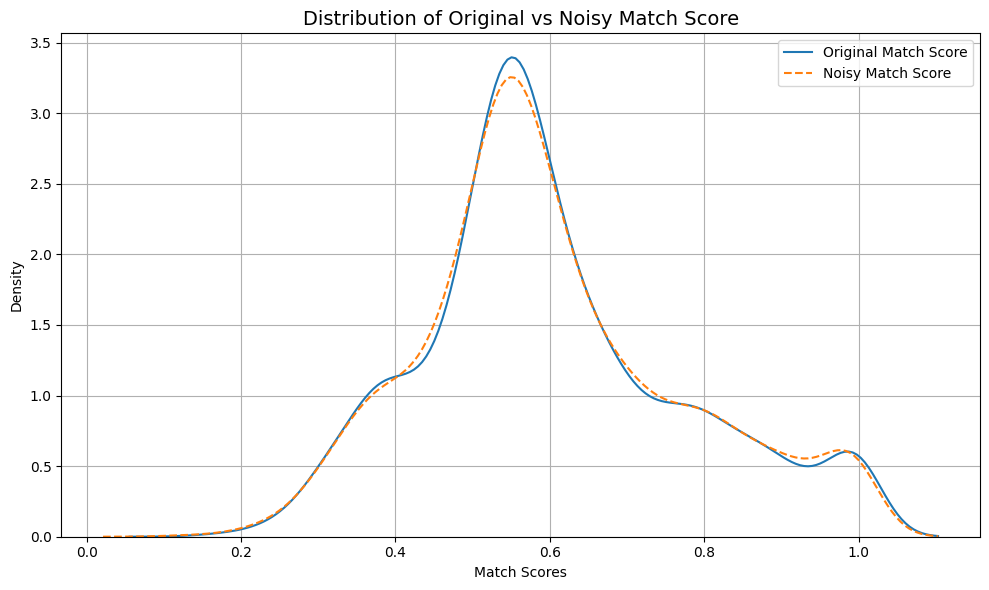

In [422]:
plt.figure(figsize=(10,6))
sns.kdeplot(df["match_score"],label="Original Match Score")
sns.kdeplot(df["match_score_noisy"],label="Noisy Match Score",linestyle='--')

plt.title("Distribution of Original vs Noisy Match Score", fontsize=14)
plt.xlabel("Match Scores")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [423]:
X = df[["carbs","protein","fat","fiber","calories","goal_tag","diet_type"]]
y = df["match_score_noisy"]

In [424]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [425]:
mlflow.set_experiment("Noizy Data 1.0")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        # Train model
        model.fit(X_train, y_train)

        # Predict
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Evaluate
        model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
        model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

        # Log metrics
        mlflow.log_metrics({
            "train_mae": model_train_mae,
            "train_rmse": model_train_rmse,
            "train_r2": model_train_r2,
            "test_mae": model_test_mae,
            "test_rmse": model_test_rmse,
            "test_r2": model_test_r2
        })

        # Log model
        if model_name == "XGBRegressor":
            mlflow.xgboost.log_model(model,model_name)
        elif model_name == "CatBoosting Regressor":
            mlflow.catboost.log_model(model, model_name)
        else:
            mlflow.sklearn.log_model(model, model_name)

        # Print results to console
        print(f"Model Performance on training set for {model_name}")
        print('- Root MeanSquared Error: {:.4f}'.format(model_train_rmse))
        print('- Mean Absolute Error: {:.4f}'.format(model_train_mae))
        print('- R2 Score: {:.4f}'.format(model_train_r2))
        print("\n")
        print(f"Model Performance on test set for {model_name}")
        print('- Root MeanSquared Error: {:.4f}'.format(model_test_rmse))
        print('- Mean Absolute Error: {:.4f}'.format(model_test_mae))
        print('- R2 Score: {:.4f}'.format(model_test_r2))
        print("----------------------------------------------------------------")

2025/07/11 18:24:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 18:25:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 18:25:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model Performance on training set for Linear Regression
- Root MeanSquared Error: 0.0934
- Mean Absolute Error: 0.0721
- R2 Score: 0.7013


Model Performance on test set for Linear Regression
- Root MeanSquared Error: 0.1028
- Mean Absolute Error: 0.0776
- R2 Score: 0.6384
----------------------------------------------------------------
🏃 View run Linear Regression at: http://127.0.0.1:5000/#/experiments/799502646512637603/runs/de4e020157c046869dd7f2c7ea8eaf76
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/799502646512637603


2025/07/11 18:25:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 18:25:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model Performance on training set for Lasso
- Root MeanSquared Error: 0.1709
- Mean Absolute Error: 0.1336
- R2 Score: 0.0000


Model Performance on test set for Lasso
- Root MeanSquared Error: 0.1709
- Mean Absolute Error: 0.1334
- R2 Score: -0.0000
----------------------------------------------------------------
🏃 View run Lasso at: http://127.0.0.1:5000/#/experiments/799502646512637603/runs/39be2cc579964b7e88a78ce50bc22bc8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/799502646512637603


2025/07/11 18:25:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 18:25:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model Performance on training set for Ridge
- Root MeanSquared Error: 0.0934
- Mean Absolute Error: 0.0721
- R2 Score: 0.7013


Model Performance on test set for Ridge
- Root MeanSquared Error: 0.1028
- Mean Absolute Error: 0.0776
- R2 Score: 0.6385
----------------------------------------------------------------
🏃 View run Ridge at: http://127.0.0.1:5000/#/experiments/799502646512637603/runs/e3979250e4c64d9a99707053a2bb17c6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/799502646512637603


2025/07/11 18:25:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 18:25:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model Performance on training set for K-Neighbors Regressor
- Root MeanSquared Error: 0.0288
- Mean Absolute Error: 0.0199
- R2 Score: 0.9715


Model Performance on test set for K-Neighbors Regressor
- Root MeanSquared Error: 0.0377
- Mean Absolute Error: 0.0254
- R2 Score: 0.9514
----------------------------------------------------------------
🏃 View run K-Neighbors Regressor at: http://127.0.0.1:5000/#/experiments/799502646512637603/runs/86002e0bd5de46b6a3b45336c5d69c62
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/799502646512637603


2025/07/11 18:25:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Performance on training set for Decision Tree
- Root MeanSquared Error: 0.0083
- Mean Absolute Error: 0.0037
- R2 Score: 0.9976


Model Performance on test set for Decision Tree
- Root MeanSquared Error: 0.0363
- Mean Absolute Error: 0.0265
- R2 Score: 0.9548
----------------------------------------------------------------
🏃 View run Decision Tree at: http://127.0.0.1:5000/#/experiments/799502646512637603/runs/e44bc5b81dc84025973a6f99123c7cf9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/799502646512637603


2025/07/11 18:25:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 18:25:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Performance on training set for Random Forest Regressor
- Root MeanSquared Error: 0.0128
- Mean Absolute Error: 0.0096
- R2 Score: 0.9944


Model Performance on test set for Random Forest Regressor
- Root MeanSquared Error: 0.0315
- Mean Absolute Error: 0.0217
- R2 Score: 0.9660
----------------------------------------------------------------
🏃 View run Random Forest Regressor at: http://127.0.0.1:5000/#/experiments/799502646512637603/runs/5f0487559cef4cfdae7343f6beefade7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/799502646512637603


2025/07/11 18:25:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Data Science Learning\Projects\NutriGoal-AI-Powered-Personalized-Diet-Planner\dietenv\lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [18:25:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/07/11 18:25:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Performance on training set for XGBRegressor
- Root MeanSquared Error: 0.0111
- Mean Absolute Error: 0.0081
- R2 Score: 0.9958


Model Performance on test set for XGBRegressor
- Root MeanSquared Error: 0.0320
- Mean Absolute Error: 0.0226
- R2 Score: 0.9649
----------------------------------------------------------------
🏃 View run XGBRegressor at: http://127.0.0.1:5000/#/experiments/799502646512637603/runs/a7100c96e7db430f873b79b74b16474a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/799502646512637603


2025/07/11 18:25:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 18:25:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Performance on training set for CatBoosting Regressor
- Root MeanSquared Error: 0.0160
- Mean Absolute Error: 0.0127
- R2 Score: 0.9912


Model Performance on test set for CatBoosting Regressor
- Root MeanSquared Error: 0.0246
- Mean Absolute Error: 0.0184
- R2 Score: 0.9793
----------------------------------------------------------------
🏃 View run CatBoosting Regressor at: http://127.0.0.1:5000/#/experiments/799502646512637603/runs/7722c47abc3942a48032bac2cb3806a0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/799502646512637603


2025/07/11 18:25:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 18:25:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Performance on training set for AdaBoost Regressor
- Root MeanSquared Error: 0.0650
- Mean Absolute Error: 0.0533
- R2 Score: 0.8555


Model Performance on test set for AdaBoost Regressor
- Root MeanSquared Error: 0.0691
- Mean Absolute Error: 0.0559
- R2 Score: 0.8367
----------------------------------------------------------------
🏃 View run AdaBoost Regressor at: http://127.0.0.1:5000/#/experiments/799502646512637603/runs/426abe3c79a34f5886e493543712876e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/799502646512637603


### Hyperparameter tuning

For hyper parameter tuning we are only considering models which gave close to optimal performance like catboost and Random Forest

In [428]:
from sklearn.model_selection import GridSearchCV

In [429]:
models = {
    "KNeighborsRegressor" : KNeighborsRegressor(),
    "XGBRegressor" : XGBRegressor(),
    "RandomForestRegressor" : RandomForestRegressor(),
    "CatBoostRegressor" : CatBoostRegressor()
}

In [430]:
param_grid = {
    "KNeighborsRegressor" : {
        "n_neighbors":[2,5,10],
        "weights":['uniform','distance']
    },
    "XGBRegressor" : {
        "loss":["squared_error","absolute_error"],
        "learning_rate":[0.01,0.05,0.1,0.2],
        "n_estimators":[10,20,50,100]
    },
    "RandomForestRegressor" : {
        "n_estimators":[10,50,100,200], 
        "max_depth": [1,5,10,20,None],
        "criterion":["squared_error", "absolute_error"]
    },
    "CatBoostRegressor" : {
        "iterations":[10,20,100,200],
        "learning_rate":[0.01,0.05,0.1]
    }
 }

In [431]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [432]:
import joblib

In [433]:
mlflow.set_experiment("Hyperparameter Tuning")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        # Train model
        grid = GridSearchCV(model,param_grid[model_name],cv=5,n_jobs=-1)
        grid.fit(X_train,y_train)

        # Get Best Model
        best_model = grid.best_estimator_

        
        # Predict
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        # Evaluate
        model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
        model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

        # Log metrics
        mlflow.log_metrics({
            "train_mae": model_train_mae,
            "train_rmse": model_train_rmse,
            "train_r2": model_train_r2,
            "test_mae": model_test_mae,
            "test_rmse": model_test_rmse,
            "test_r2": model_test_r2
        })

        # Log params
        mlflow.log_params(grid.best_params_)

        # Log model
        if model_name == "XGBRegressor":
            mlflow.xgboost.log_model(best_model,model_name)
        elif model_name == "CatBoosting Regressor":
            mlflow.catboost.log_model(best_model, model_name)
        else:
            mlflow.sklearn.log_model(best_model, model_name)

        # Print results to console
        print(f"Model Performance on training set for {model_name}")
        print('- Root MeanSquared Error: {:.4f}'.format(model_train_rmse))
        print('- Mean Absolute Error: {:.4f}'.format(model_train_mae))
        print('- R2 Score: {:.4f}'.format(model_train_r2))
        print("\n")
        print(f"Model Performance on test set for {model_name}")
        print('- Root MeanSquared Error: {:.4f}'.format(model_test_rmse))
        print('- Mean Absolute Error: {:.4f}'.format(model_test_mae))
        print('- R2 Score: {:.4f}'.format(model_test_r2))
        print("\n")
        print(f"Best Parameters {grid.best_params_}")
        print("----------------------------------------------------------------")

        # Saving Models 
        joblib.dump(best_model,f'{model_name}.pkl')

2025/07/11 18:25:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 18:25:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Performance on training set for KNeighborsRegressor
- Root MeanSquared Error: 0.0084
- Mean Absolute Error: 0.0037
- R2 Score: 0.9976


Model Performance on test set for KNeighborsRegressor
- Root MeanSquared Error: 0.0365
- Mean Absolute Error: 0.0246
- R2 Score: 0.9545


Best Parameters {'n_neighbors': 5, 'weights': 'distance'}
----------------------------------------------------------------
🏃 View run KNeighborsRegressor at: http://127.0.0.1:5000/#/experiments/649973813408310596/runs/b3397d9bf03f4e6481b4d666a8f213ae
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/649973813408310596


C:\Data Science Learning\Projects\NutriGoal-AI-Powered-Personalized-Diet-Planner\dietenv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
1 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Data Science Learning\Projects\NutriGoal-AI-Powered-Personalized-Diet-Planner\dietenv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Data Science Learning\Projects\NutriGoal-AI-Powered-Personalized-Diet-Planner\dietenv\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  F

Model Performance on training set for XGBRegressor
- Root MeanSquared Error: 0.0163
- Mean Absolute Error: 0.0127
- R2 Score: 0.9909


Model Performance on test set for XGBRegressor
- Root MeanSquared Error: 0.0296
- Mean Absolute Error: 0.0216
- R2 Score: 0.9699


Best Parameters {'learning_rate': 0.1, 'loss': 'squared_error', 'n_estimators': 100}
----------------------------------------------------------------
🏃 View run XGBRegressor at: http://127.0.0.1:5000/#/experiments/649973813408310596/runs/dee9730b81ae4d718f7205ad6294f783
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/649973813408310596


2025/07/11 18:27:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 18:27:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Performance on training set for RandomForestRegressor
- Root MeanSquared Error: 0.0130
- Mean Absolute Error: 0.0097
- R2 Score: 0.9942


Model Performance on test set for RandomForestRegressor
- Root MeanSquared Error: 0.0318
- Mean Absolute Error: 0.0219
- R2 Score: 0.9653


Best Parameters {'criterion': 'absolute_error', 'max_depth': 20, 'n_estimators': 100}
----------------------------------------------------------------
🏃 View run RandomForestRegressor at: http://127.0.0.1:5000/#/experiments/649973813408310596/runs/366867c809eb4759a8dbbdfcf36dc6ba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/649973813408310596
0:	learn: 0.1600594	total: 3.02ms	remaining: 601ms
1:	learn: 0.1509334	total: 4.38ms	remaining: 433ms
2:	learn: 0.1407045	total: 5.92ms	remaining: 389ms
3:	learn: 0.1323476	total: 7.17ms	remaining: 351ms
4:	learn: 0.1246143	total: 8.41ms	remaining: 328ms
5:	learn: 0.1166526	total: 9.67ms	remaining: 313ms
6:	learn: 0.1102329	total: 11ms	remaining: 302ms
7:	

2025/07/11 18:27:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


141:	learn: 0.0228269	total: 201ms	remaining: 82.1ms
142:	learn: 0.0227570	total: 202ms	remaining: 80.7ms
143:	learn: 0.0227357	total: 204ms	remaining: 79.3ms
144:	learn: 0.0227140	total: 205ms	remaining: 77.9ms
145:	learn: 0.0226270	total: 207ms	remaining: 76.4ms
146:	learn: 0.0225575	total: 208ms	remaining: 75.1ms
147:	learn: 0.0224874	total: 210ms	remaining: 73.6ms
148:	learn: 0.0223899	total: 211ms	remaining: 72.2ms
149:	learn: 0.0223081	total: 212ms	remaining: 70.8ms
150:	learn: 0.0222896	total: 214ms	remaining: 69.3ms
151:	learn: 0.0222059	total: 215ms	remaining: 67.9ms
152:	learn: 0.0221837	total: 216ms	remaining: 66.5ms
153:	learn: 0.0221535	total: 218ms	remaining: 65.1ms
154:	learn: 0.0221074	total: 219ms	remaining: 63.7ms
155:	learn: 0.0220748	total: 221ms	remaining: 62.3ms
156:	learn: 0.0220333	total: 222ms	remaining: 60.8ms
157:	learn: 0.0219739	total: 223ms	remaining: 59.4ms
158:	learn: 0.0219257	total: 225ms	remaining: 57.9ms
159:	learn: 0.0218965	total: 226ms	remaining: 

2025/07/11 18:27:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Performance on training set for CatBoostRegressor
- Root MeanSquared Error: 0.0205
- Mean Absolute Error: 0.0161
- R2 Score: 0.9856


Model Performance on test set for CatBoostRegressor
- Root MeanSquared Error: 0.0271
- Mean Absolute Error: 0.0198
- R2 Score: 0.9748


Best Parameters {'iterations': 200, 'learning_rate': 0.1}
----------------------------------------------------------------
🏃 View run CatBoostRegressor at: http://127.0.0.1:5000/#/experiments/649973813408310596/runs/32df004c26f2495bbe366fdeb504566a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/649973813408310596
